In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install tensorboardX

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 5.3 MB/s eta 0:00:00


In [3]:
import os
from sklearn.model_selection import train_test_split

import torch
import cv2
import numpy as np
from torch.utils.data import Dataset, DataLoader


import timeit
from datetime import datetime
import socket
import os
import glob
from tqdm import tqdm

import torch
from tensorboardX import SummaryWriter
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.autograd import Variable

import matplotlib.pyplot as plt
import seaborn as sns
import timeit
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)
# from pathlib import Path

In [4]:
class Path(object):
    @staticmethod
    def db_dir(database):
        if database == 'ucf101':
            # folder that contains class labels
            root_dir = '/kaggle/input/ucf101-frames-per-video/ucf101/ucf101'

            # Save preprocess data into output_dir
            output_dir = '/kaggle/input/ucf101-frames-per-video/ucf101/ucf101'

            return root_dir, output_dir
        elif database == 'hmdb51':
            # folder that contains class labels
            root_dir = '/Path/to/hmdb-51'

            output_dir = '/path/to/VAR/hmdb51'

            return root_dir, output_dir
        else:
            print('Database {} not available.'.format(database))
            raise NotImplementedError

    @staticmethod
    def model_dir():
        return '/kaggle/working/c3d-pretrained.pth'

In [5]:
class VideoDataset(Dataset):
    r"""A Dataset for a folder of videos. Expects the directory structure to be
    directory->[train/val/test]->[class labels]->[videos]. Initializes with a list
    of all file names, along with an array of labels, with label being automatically
    inferred from the respective folder names.

        Args:
            dataset (str): Name of dataset. Defaults to 'ucf101'.
            split (str): Determines which folder of the directory the dataset will read from. Defaults to 'train'.
            clip_len (int): Determines how many frames are there in each clip. Defaults to 16.
            preprocess (bool): Determines whether to preprocess dataset. Default is False.
            selected_classes (list, optional): List of class names to include. If None, all classes are used. Defaults to None.
    """

    def __init__(self, dataset='ucf101', split='train', clip_len=16, preprocess=False, selected_classes=None):
        self.root_dir, self.output_dir = Path.db_dir(dataset)
        folder = os.path.join(self.output_dir, split)
        self.clip_len = clip_len
        self.split = split
        self.selected_classes = selected_classes  # New parameter to filter classes

        # The following three parameters are chosen as described in the paper section 4.1
        self.resize_height = 128
        self.resize_width = 171
        self.crop_size = 112

        if not self.check_integrity():
            raise RuntimeError('Dataset not found or corrupted.' +
                               ' You need to download it from official website.')

        if (not self.check_preprocess()) or preprocess:
            print('Preprocessing of {} dataset, this will take long, but it will be done only once.'.format(dataset))
            self.preprocess()

        # Obtain all the filenames of files inside all the class folders
        # Going through each class folder one at a time
        self.fnames, labels = [], []
        
        # Get all available classes in the folder
        available_classes = sorted(os.listdir(folder))
        
        # If selected_classes is provided, filter the classes
        if self.selected_classes is not None:
            # Validate that the selected classes exist in the dataset
            for cls in self.selected_classes:
                if cls not in available_classes:
                    print(f"Warning: Selected class '{cls}' not found in the dataset.")
            
            # Filter the available classes to only include selected ones
            class_list = [cls for cls in available_classes if cls in self.selected_classes]
            
            if len(class_list) == 0:
                raise ValueError("None of the selected classes were found in the dataset.")
            
            print(f"Using {len(class_list)} selected classes out of {len(available_classes)} available classes.")
        else:
            class_list = available_classes
        
        # Now iterate only through the filtered class list
        for label in class_list:
            for fname in os.listdir(os.path.join(folder, label)):
                self.fnames.append(os.path.join(folder, label, fname))
                labels.append(label)

        assert len(labels) == len(self.fnames)
        print('Number of {} videos: {:d}'.format(split, len(self.fnames)))

        # Prepare a mapping between the label names (strings) and indices (ints)
        self.label2index = {label: index for index, label in enumerate(sorted(set(labels)))}
        # Convert the list of label names into an array of label indices
        self.label_array = np.array([self.label2index[label] for label in labels], dtype=int)

        # if dataset == "ucf101":
        #     # Save the mapping for the selected classes (or all classes if no selection)
        #     labels_path = '/kaggle/input/ucf101-frames-per-video/ucf_labels.txt'
        #     out_path = labels_path.split("/")[-1]
        #     out_path = os.path.join("kaggle/working", out_path)
        #     print(out_path)
        #     if not os.path.exists(labels_path) or self.selected_classes is not None:
        #         with open(out_path, 'w') as f:
        #             for id, label in enumerate(sorted(self.label2index)):
        #                 f.writelines(str(id+1) + ' ' + label + '\n')

        # elif dataset == 'hmdb51':
        #     if not os.path.exists('dataloaders/hmdb_labels.txt'):
        #         with open('dataloaders/hmdb_labels.txt', 'w') as f:
        #             for id, label in enumerate(sorted(self.label2index)):
        #                 f.writelines(str(id+1) + ' ' + label + '\n')

    # Rest of the methods remain the same
    def __len__(self):
        return len(self.fnames)

    def __getitem__(self, index):
        # Loading and preprocessing.
        buffer = self.load_frames(self.fnames[index])  # dtype is float32, values 0-255
    
        # Normalize to [0, 1]
        buffer /= 255.0
    
        buffer = self.crop(buffer, self.clip_len, self.crop_size)
        labels = np.array(self.label_array[index])
    
        if self.split == 'test':
            # Perform data augmentation
            buffer = self.randomflip(buffer)
    
        # buffer = self.normalize(buffer)  # <- avoid custom normalization for now
        buffer = self.to_tensor(buffer)  # likely converts from HWC to CHW and swaps axes
    
        return torch.from_numpy(buffer), torch.from_numpy(labels)


    def check_integrity(self):
        if not os.path.exists(self.root_dir):
            return False
        else:
            return True

    def check_preprocess(self):
        # TODO: Check image size in output_dir
        if not os.path.exists(self.output_dir):
            return False
        elif not os.path.exists(os.path.join(self.output_dir, 'train')):
            return False

        for ii, video_class in enumerate(os.listdir(os.path.join(self.output_dir, 'train'))):
            for video in os.listdir(os.path.join(self.output_dir, 'train', video_class)):
                video_name = os.path.join(os.path.join(self.output_dir, 'train', video_class, video),
                                    sorted(os.listdir(os.path.join(self.output_dir, 'train', video_class, video)))[0])
                image = cv2.imread(video_name)
                if np.shape(image)[0] != 128 or np.shape(image)[1] != 171:
                    return False
                else:
                    break

            if ii == 10:
                break

        return True

    def preprocess(self):
        if not os.path.exists(self.output_dir):
            os.mkdir(self.output_dir)
            os.mkdir(os.path.join(self.output_dir, 'train'))
            os.mkdir(os.path.join(self.output_dir, 'val'))
            os.mkdir(os.path.join(self.output_dir, 'test'))

        # Split train/val/test sets
        for file in os.listdir(self.root_dir):
            # If selected_classes is provided, skip classes not in the list
            if self.selected_classes is not None and file not in self.selected_classes:
                continue
                
            file_path = os.path.join(self.root_dir, file)
            video_files = [name for name in os.listdir(file_path)]

            train_and_valid, test = train_test_split(video_files, test_size=0.2, random_state=42)
            train, val = train_test_split(train_and_valid, test_size=0.2, random_state=42)

            train_dir = os.path.join(self.output_dir, 'train', file)
            val_dir = os.path.join(self.output_dir, 'val', file)
            test_dir = os.path.join(self.output_dir, 'test', file)

            if not os.path.exists(train_dir):
                os.mkdir(train_dir)
            if not os.path.exists(val_dir):
                os.mkdir(val_dir)
            if not os.path.exists(test_dir):
                os.mkdir(test_dir)

            for video in train:
                self.process_video(video, file, train_dir)

            for video in val:
                self.process_video(video, file, val_dir)

            for video in test:
                self.process_video(video, file, test_dir)

        print('Preprocessing finished.')

    def process_video(self, video, action_name, save_dir):
        # Initialize a VideoCapture object to read video data into a numpy array
        video_filename = video.split('.')[0]
        if not os.path.exists(os.path.join(save_dir, video_filename)):
            os.mkdir(os.path.join(save_dir, video_filename))

        capture = cv2.VideoCapture(os.path.join(self.root_dir, action_name, video))

        frame_count = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))

        # Make sure splited video has at least 16 frames
        EXTRACT_FREQUENCY = 4
        if frame_count // EXTRACT_FREQUENCY <= 16:
            EXTRACT_FREQUENCY -= 1
            if frame_count // EXTRACT_FREQUENCY <= 16:
                EXTRACT_FREQUENCY -= 1
                if frame_count // EXTRACT_FREQUENCY <= 16:
                    EXTRACT_FREQUENCY -= 1

        count = 0
        i = 0
        retaining = True

        while (count < frame_count and retaining):
            retaining, frame = capture.read()
            if frame is None:
                continue

            if count % EXTRACT_FREQUENCY == 0:
                if (frame_height != self.resize_height) or (frame_width != self.resize_width):
                    frame = cv2.resize(frame, (self.resize_width, self.resize_height))
                cv2.imwrite(filename=os.path.join(save_dir, video_filename, '0000{}.jpg'.format(str(i))), img=frame)
                i += 1
            count += 1

        # Release the VideoCapture once it is no longer needed
        capture.release()

    def randomflip(self, buffer):
        """Horizontally flip the given image and ground truth randomly with a probability of 0.5."""

        if np.random.random() < 0.5:
            for i, frame in enumerate(buffer):
                frame = cv2.flip(buffer[i], flipCode=1)
                buffer[i] = cv2.flip(frame, flipCode=1)

        return buffer


    def normalize(self, buffer):
        for i, frame in enumerate(buffer):
            frame -= np.array([[[90.0, 98.0, 102.0]]])
            buffer[i] = frame

        return buffer

    def to_tensor(self, buffer):
        return buffer.transpose((3, 0, 1, 2))

    def load_frames(self, file_dir):
        frames = sorted([os.path.join(file_dir, img) for img in os.listdir(file_dir)])
        frame_count = len(frames)
        buffer = np.empty((frame_count, self.resize_height, self.resize_width, 3), np.dtype('float32'))
        for i, frame_name in enumerate(frames):
            frame = np.array(cv2.imread(frame_name)).astype(np.float64)
            buffer[i] = frame

        return buffer

    def crop(self, buffer, clip_len, crop_size):
        # randomly select time index for temporal jittering
        time_index = np.random.randint(buffer.shape[0] - clip_len)

        # Randomly select start indices in order to crop the video
        height_index = np.random.randint(buffer.shape[1] - crop_size)
        width_index = np.random.randint(buffer.shape[2] - crop_size)

        # Crop and jitter the video using indexing. The spatial crop is performed on
        # the entire array, so each frame is cropped in the same location. The temporal
        # jitter takes place via the selection of consecutive frames
        buffer = buffer[time_index:time_index + clip_len,
                 height_index:height_index + crop_size,
                 width_index:width_index + crop_size, :]

        return buffer

In [6]:
# Define your 10 classes from UCF-101 
selected_classes = [
    'PlayingPiano',
    'TaiChi',
    'Swing',
    'HorseRace',
    'PlayingTabla',
    'Mixing',
    'Fencing',
    'Basketball',
    'Punch',
    'Diving'
]

# Initialize dataset with only the selected classes
train_dataset = VideoDataset(
    dataset='ucf101',
    split='train',
    clip_len=16,
    preprocess=False,  # Set to True if you need preprocessing
    selected_classes=selected_classes  # Pass the list of 10 classes you want to use
)

Using 10 selected classes out of 101 available classes.
Number of train videos: 802


In [7]:
# You can also create validation and test datasets with the same class filtering
val_dataset = VideoDataset(
    dataset='ucf101',
    split='val',
    clip_len=16,
    preprocess=False,
    selected_classes=selected_classes
)

test_dataset = VideoDataset(
    dataset='ucf101',
    split='test',
    clip_len=16,
    preprocess=False,
    selected_classes=selected_classes
)

# Create DataLoaders as usual
train_dataloader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4
)

Using 10 selected classes out of 101 available classes.
Number of val videos: 204
Using 10 selected classes out of 101 available classes.
Number of test videos: 256


In [8]:
data = next(iter(train_dataloader))
len(data)

2

In [9]:
type(data[0]), type(data[1]), data[0].shape, data[1].shape

(torch.Tensor,
 torch.Tensor,
 torch.Size([32, 3, 16, 112, 112]),
 torch.Size([32]))

Using 10 selected classes out of 101 available classes.
Number of train videos: 802
Video shape: torch.Size([1, 3, 16, 112, 112])
Label: tensor([6])
<class 'torch.Tensor'> torch.Size([1, 3, 16, 112, 112]) torch.float32
tensor(0.7647) tensor(0.)


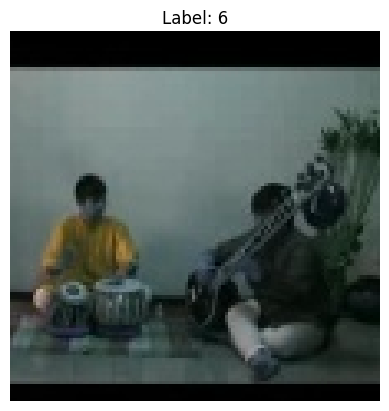

In [10]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Instantiate dataset
dataset = VideoDataset(dataset='ucf101', split='train', clip_len=16, preprocess=False, selected_classes = selected_classes)

# Create DataLoader
loader = DataLoader(dataset, batch_size=1, shuffle=True)

# Sample one batch
for batch in loader:
    videos, labels = batch
    print("Video shape:", videos.shape)  # Should be [1, 3, 16, 112, 112]
    print("Label:", labels)

    # Visualize the first frame in the clip (after permuting for plotting)
    video = videos[0].permute(1, 2, 3, 0).numpy()  # [T, H, W, C]
    print(type(videos), videos.shape, videos.dtype)
    print(videos.max(), videos.min())
    # Renormalize from [0, 1] → [0, 255] for display
    video = (video * 255.0).clip(0, 255).astype(np.uint8)
    
    frame = video[0].astype(np.uint8)

    plt.imshow(frame)
    plt.title(f"Label: {labels.item()}")
    plt.axis("off")
    plt.show()
    break

In [11]:
import torch
import torch.nn as nn

class C3D(nn.Module):
    """
    The C3D network.
    """

    def __init__(self, num_classes, pretrained=False):
        super(C3D, self).__init__()

        self.conv1 = nn.Conv3d(3, 64, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool1 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))

        self.conv2 = nn.Conv3d(64, 128, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv3a = nn.Conv3d(128, 256, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv3b = nn.Conv3d(256, 256, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv4a = nn.Conv3d(256, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv4b = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool4 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv5a = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv5b = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool5 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=(0, 1, 1))

        self.fc6 = nn.Linear(8192, 4096)
        self.fc7 = nn.Linear(4096, 4096)
        self.fc8 = nn.Linear(4096, num_classes)

        self.dropout = nn.Dropout(p=0.5)

        self.relu = nn.ReLU()

        self.__init_weight()

        if pretrained:
            self.__load_pretrained_weights()

    def forward(self, x):

        x = self.relu(self.conv1(x))
        x = self.pool1(x)

        x = self.relu(self.conv2(x))
        x = self.pool2(x)

        x = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool3(x)

        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))
        x = self.pool4(x)

        x = self.relu(self.conv5a(x))
        x = self.relu(self.conv5b(x))
        x = self.pool5(x)

        x = x.view(-1, 8192)
        x = self.relu(self.fc6(x))
        x = self.dropout(x)
        x = self.relu(self.fc7(x))
        x = self.dropout(x)

        logits = self.fc8(x)

        return logits

    def __load_pretrained_weights(self):
        """Initialiaze network."""
        corresp_name = {
                        # Conv1
                        "features.0.weight": "conv1.weight",
                        "features.0.bias": "conv1.bias",
                        # Conv2
                        "features.3.weight": "conv2.weight",
                        "features.3.bias": "conv2.bias",
                        # Conv3a
                        "features.6.weight": "conv3a.weight",
                        "features.6.bias": "conv3a.bias",
                        # Conv3b
                        "features.8.weight": "conv3b.weight",
                        "features.8.bias": "conv3b.bias",
                        # Conv4a
                        "features.11.weight": "conv4a.weight",
                        "features.11.bias": "conv4a.bias",
                        # Conv4b
                        "features.13.weight": "conv4b.weight",
                        "features.13.bias": "conv4b.bias",
                        # Conv5a
                        "features.16.weight": "conv5a.weight",
                        "features.16.bias": "conv5a.bias",
                         # Conv5b
                        "features.18.weight": "conv5b.weight",
                        "features.18.bias": "conv5b.bias",
                        # fc6
                        "classifier.0.weight": "fc6.weight",
                        "classifier.0.bias": "fc6.bias",
                        # fc7
                        "classifier.3.weight": "fc7.weight",
                        "classifier.3.bias": "fc7.bias",
                        }

        p_dict = torch.load(Path.model_dir())
        s_dict = self.state_dict()
        for name in p_dict:
            if name not in corresp_name:
                continue
            s_dict[corresp_name[name]] = p_dict[name]
        self.load_state_dict(s_dict)

    def __init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                # n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                # m.weight.data.normal_(0, math.sqrt(2. / n))
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm3d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

def get_1x_lr_params(model):
    """
    This generator returns all the parameters for conv and two fc layers of the net.
    """
    b = [model.conv1, model.conv2, model.conv3a, model.conv3b, model.conv4a, model.conv4b,
         model.conv5a, model.conv5b, model.fc6, model.fc7]
    for i in range(len(b)):
        for k in b[i].parameters():
            if k.requires_grad:
                yield k

def get_10x_lr_params(model):
    """
    This generator returns all the parameters for the last fc layer of the net.
    """
    b = [model.fc8]
    for j in range(len(b)):
        for k in b[j].parameters():
            if k.requires_grad:
                yield k

In [12]:
inputs = torch.rand(1, 3, 16, 112, 112)
net = C3D(num_classes=10, pretrained=False)

outputs = net.forward(inputs)
print(outputs.size())

torch.Size([1, 10])


In [13]:
def get_class_names(dataset_path, selected_classes=None):
    """Get class names from the dataset directory."""
    train_dir = os.path.join(dataset_path, 'train')
    
    if not os.path.exists(train_dir):
        raise FileNotFoundError(f"Train directory not found: {train_dir}")
    
    all_classes = sorted(os.listdir(train_dir))
    
    if selected_classes is not None:
        # Filter classes to only include selected ones
        class_names = [cls for cls in all_classes if cls in selected_classes]
        if not class_names:
            raise ValueError("None of the selected classes were found in the dataset.")
    else:
        class_names = all_classes
        
    return class_names


def evaluate_model(model, test_dataloader, device, criterion, class_names):
    """Evaluate the model on the test set and calculate metrics."""
    model.eval()
    start_time = timeit.default_timer()
    
    # Initialize metrics
    running_loss = 0.0
    all_preds = []
    all_labels = []
    all_probs = []
    
    # Evaluation loop
    with torch.no_grad():
        for inputs, labels in tqdm(test_dataloader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            
            # Calculate probabilities
            probs = nn.Softmax(dim=1)(outputs)
            all_probs.extend(probs.cpu().numpy())
            
            # Get predictions
            preds = torch.max(probs, 1)[1]
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Calculate loss
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
    
    # Calculate overall metrics
    test_size = len(test_dataloader.dataset)
    loss = running_loss / test_size
    accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
    
    # Convert lists to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # Calculate classification report
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    
    # Calculate F1, precision, and recall scores
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    # Execution time
    stop_time = timeit.default_timer()
    execution_time = stop_time - start_time
    
    metrics = {
        'loss': loss,
        'accuracy': accuracy,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'confusion_matrix': conf_matrix,
        'classification_report': report,
        'execution_time': execution_time,
        'all_probs': np.array(all_probs),
        'all_preds': all_preds,
        'all_labels': all_labels
    }
    
    return metrics


def plot_confusion_matrix(conf_matrix, class_names, output_path="confusion_matrix.png"):
    """Plot the confusion matrix as a heatmap."""
    plt.figure(figsize=(12, 10))
    
    # Normalize confusion matrix
    conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    
    # Create a heatmap
    sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    # plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


def plot_metrics_by_class(report, class_names, output_path="class_metrics.png"):
    """Plot precision, recall, and F1-score for each class."""
    # Extract class metrics
    metrics_df = pd.DataFrame({
        'Precision': [report[class_name]['precision'] for class_name in class_names],
        'Recall': [report[class_name]['recall'] for class_name in class_names],
        'F1-Score': [report[class_name]['f1-score'] for class_name in class_names]
    }, index=class_names)
    
    # Plot
    plt.figure(figsize=(14, 8))
    metrics_df.plot(kind='bar', rot=45)
    plt.title('Performance Metrics by Class')
    plt.ylabel('Score')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    # plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


def print_metrics_summary(metrics, class_names):
    """Print a summary of the evaluation metrics."""
    print("\n" + "="*50)
    print("MODEL EVALUATION SUMMARY")
    print("="*50)
    
    print(f"Test Loss: {metrics['loss']:.4f}")
    print(f"Test Accuracy: {metrics['accuracy']:.4f} ({metrics['accuracy']*100:.2f}%)")
    print(f"F1 Score (Weighted): {metrics['f1_score']:.4f}")
    print(f"Precision (Weighted): {metrics['precision']:.4f}")
    print(f"Recall (Weighted): {metrics['recall']:.4f}")
    print(f"Execution Time: {metrics['execution_time']:.2f} seconds")
    
    # Print per-class metrics
    print("\nPer-Class Metrics:")
    print("-"*50)
    report = metrics['classification_report']
    for class_name in class_names:
        print(f"{class_name}:")
        print(f"  Precision: {report[class_name]['precision']:.4f}")
        print(f"  Recall: {report[class_name]['recall']:.4f}")
        print(f"  F1-Score: {report[class_name]['f1-score']:.4f}")
        print(f"  Support: {report[class_name]['support']}")
        print()


def save_metrics_to_csv(metrics, class_names, output_path="model_evaluation_results.csv"):
    """Save the evaluation metrics to a CSV file."""
    # Overall metrics
    overall_metrics = {
        'Metric': ['Loss', 'Accuracy', 'F1 Score (Weighted)', 'Precision (Weighted)', 'Recall (Weighted)'],
        'Value': [
            metrics['loss'],
            metrics['accuracy'],
            metrics['f1_score'],
            metrics['precision'],
            metrics['recall']
        ]
    }
    
    overall_df = pd.DataFrame(overall_metrics)
    
    # Per-class metrics
    class_metrics = []
    report = metrics['classification_report']
    
    for class_name in class_names:
        class_metrics.append({
            'Class': class_name,
            'Precision': report[class_name]['precision'],
            'Recall': report[class_name]['recall'],
            'F1-Score': report[class_name]['f1-score'],
            'Support': report[class_name]['support']
        })
    
    class_df = pd.DataFrame(class_metrics)
    
    # Save to CSV
    with open(output_path, 'w') as f:
        f.write("OVERALL METRICS\n")
        overall_df.to_csv(f, index=False)
        f.write("\nPER-CLASS METRICS\n")
        class_df.to_csv(f, index=False)
    
    print(f"\nMetrics saved to {output_path}")

In [14]:
# Use GPU if available else revert to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device being used:", device)

nEpochs = 50  # Number of epochs for training
resume_epoch = 0  # Default is 0, change if want to resume
useTest = True # See evolution of the test set when training
nTestInterval = 5 # Run on test set every nTestInterval epochs
snapshot = 5 # Store a model every snapshot epochs
lr = 1e-3 # Learning rate

dataset = 'ucf101' # Options: hmdb51 or ucf101

if dataset == 'hmdb51':
    num_classes=51
elif dataset == 'ucf101':
    num_classes = 101
else:
    print('We only implemented hmdb and ucf datasets.')
    raise NotImplementedError


save_dir_root = "/kaggle/working/save_dir"
if not os.path.exists(save_dir_root):
    os.mkdir(save_dir_root)
# save_dir_root = os.path.join(os.path.dirname(os.path.abspath(__file__)))
# exp_name = os.path.dirname(os.path.abspath(__file__)).split('/')[-1]

if resume_epoch != 0:
    runs = sorted(glob.glob(os.path.join(save_dir_root, 'run', 'run_*')))
    run_id = int(runs[-1].split('_')[-1]) if runs else 0
else:
    runs = sorted(glob.glob(os.path.join(save_dir_root, 'run', 'run_*')))
    run_id = int(runs[-1].split('_')[-1]) + 1 if runs else 0

save_dir = os.path.join(save_dir_root, 'run', 'run_' + str(run_id))
modelName = 'C3D' # Options: C3D or R2Plus1D or R3D
saveName = modelName + '-' + dataset

Device being used: cuda


In [15]:
def train_model(dataset=dataset, save_dir=save_dir, num_classes=num_classes, lr=lr,
                num_epochs=nEpochs, save_epoch=snapshot, useTest=useTest, test_interval=nTestInterval):
    """
        Args:
            num_classes (int): Number of classes in the data
            num_epochs (int, optional): Number of epochs to train for.
    """

    if modelName == 'C3D':
        model = C3D(num_classes=num_classes, pretrained=False)
        train_params = [{'params': get_1x_lr_params(model), 'lr': lr},
                        {'params': get_10x_lr_params(model), 'lr': lr * 10}]
    elif modelName == 'R2Plus1D':
        model = R2Plus1DClassifier(num_classes=num_classes, layer_sizes=(2, 2, 2, 2))
        train_params = [{'params': get_1x_lr_params(model), 'lr': lr},
                        {'params': get_10x_lr_params(model), 'lr': lr * 10}]
    elif modelName == 'R3D':
        model = R3DClassifier(num_classes=num_classes, layer_sizes=(2, 2, 2, 2))
        train_params = model.parameters()
    else:
        print('We only implemented C3D and R2Plus1D models.')
        raise NotImplementedError
    criterion = nn.CrossEntropyLoss()  # standard crossentropy loss for classification
    optimizer = optim.SGD(train_params, lr=lr, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10,
                                          gamma=0.1)  # the scheduler divides the lr by 10 every 10 epochs

    if resume_epoch == 0:
        print("Training {} from scratch...".format(modelName))
    else:
        checkpoint = torch.load(os.path.join(save_dir, 'models', saveName + '_epoch-' + str(resume_epoch - 1) + '.pth.tar'),
                       map_location=lambda storage, loc: storage)   # Load all tensors onto the CPU
        print("Initializing weights from: {}...".format(
            os.path.join(save_dir, 'models', saveName + '_epoch-' + str(resume_epoch - 1) + '.pth.tar')))
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['opt_dict'])

    print('Total params: %.2fM' % (sum(p.numel() for p in model.parameters()) / 1000000.0))
    model.to(device)
    criterion.to(device)

    log_dir = os.path.join(save_dir, 'models', datetime.now().strftime('%b%d_%H-%M-%S') + '_' + socket.gethostname())
    writer = SummaryWriter(log_dir=log_dir)

    print('Training model on {} dataset...'.format(dataset))
    train_dataloader = DataLoader(VideoDataset(dataset=dataset, split='train',clip_len=16, selected_classes = selected_classes), batch_size=20, shuffle=True, num_workers=4)
    val_dataloader   = DataLoader(VideoDataset(dataset=dataset, split='val',  clip_len=16,selected_classes = selected_classes), batch_size=20, num_workers=4)
    test_dataloader  = DataLoader(VideoDataset(dataset=dataset, split='test', clip_len=16,selected_classes = selected_classes), batch_size=20, num_workers=4)

    trainval_loaders = {'train': train_dataloader, 'val': val_dataloader}
    trainval_sizes = {x: len(trainval_loaders[x].dataset) for x in ['train', 'val']}
    test_size = len(test_dataloader.dataset)

    for epoch in range(resume_epoch, num_epochs):
        # each epoch has a training and validation step
        for phase in ['train']:
            start_time = timeit.default_timer()

            # reset the running loss and corrects
            running_loss = 0.0
            running_corrects = 0.0

            # set model to train() or eval() mode depending on whether it is trained
            # or being validated. Primarily affects layers such as BatchNorm or Dropout.
            if phase == 'train':
                # scheduler.step() is to be called once every epoch during training
                scheduler.step()
                model.train()
            else:
                model.eval()

            for inputs, labels in tqdm(trainval_loaders[phase]):
                # move inputs and labels to the device the training is taking place on
                inputs = Variable(inputs, requires_grad=True).to(device)
                # print("Inputs max:", inputs.max(), "min:", inputs.min())
                # print("Labels unique:", labels.unique())

                labels = Variable(labels).to(device)
                optimizer.zero_grad()

                if phase == 'train':
                    outputs = model(inputs)
                else:
                    with torch.no_grad():
                        outputs = model(inputs)

                # probs = nn.Softmax(dim=1)(outputs)
                # preds = torch.max(probs, 1)[1]
                # loss = criterion(outputs, labels)
                loss = criterion(outputs, labels)
                preds = torch.max(outputs, 1)[1]

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / trainval_sizes[phase]
            epoch_acc = running_corrects.double() / trainval_sizes[phase]

            if phase == 'train':
                writer.add_scalar('data/train_loss_epoch', epoch_loss, epoch)
                writer.add_scalar('data/train_acc_epoch', epoch_acc, epoch)
            else:
                writer.add_scalar('data/val_loss_epoch', epoch_loss, epoch)
                writer.add_scalar('data/val_acc_epoch', epoch_acc, epoch)

            print("[{}] Epoch: {}/{} Loss: {} Acc: {}".format(phase, epoch+1, nEpochs, epoch_loss, epoch_acc))
            stop_time = timeit.default_timer()
            print("Execution time: " + str(stop_time - start_time) + "\n")

        if epoch % save_epoch == (save_epoch - 1):
            torch.save({
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'opt_dict': optimizer.state_dict(),
            }, os.path.join(save_dir, 'models', saveName + '_epoch-' + str(epoch) + '.pth.tar'))
            print("Save model at {}\n".format(os.path.join(save_dir, 'models', saveName + '_epoch-' + str(epoch) + '.pth.tar')))

        if useTest and epoch % test_interval == (test_interval - 1):
            model.eval()
            start_time = timeit.default_timer()

            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in tqdm(test_dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                with torch.no_grad():
                    outputs = model(inputs)
                probs = nn.Softmax(dim=1)(outputs)
                preds = torch.max(probs, 1)[1]
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / test_size
            epoch_acc = running_corrects.double() / test_size

            writer.add_scalar('data/test_loss_epoch', epoch_loss, epoch)
            writer.add_scalar('data/test_acc_epoch', epoch_acc, epoch)

            print("[test] Epoch: {}/{} Loss: {} Acc: {}".format(epoch+1, nEpochs, epoch_loss, epoch_acc))
            stop_time = timeit.default_timer()
            print("Execution time: " + str(stop_time - start_time) + "\n")

    metrics = evaluate_model(model, test_dataloader, device, criterion, class_names = selected_classes)
    # Print results summary
    print_metrics_summary(metrics, class_names = selected_classes)

    cm_path = os.path.join("kaggle/working", "confusion_matrix.png")
    plot_confusion_matrix(metrics['confusion_matrix'], selected_classes, cm_path)
    metrics_path = os.path.join("kaggle/working/", "class_metrics.png")
    plot_metrics_by_class(metrics['classification_report'], selected_classes, metrics_path)
    
    writer.close()

Training C3D from scratch...
Total params: 78.41M


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Training model on ucf101 dataset...
Using 10 selected classes out of 101 available classes.
Number of train videos: 802
Using 10 selected classes out of 101 available classes.
Number of val videos: 204
Using 10 selected classes out of 101 available classes.
Number of test videos: 256


100%|██████████| 41/41 [00:47<00:00,  1.16s/it]


[train] Epoch: 1/50 Loss: 2.9020718339078146 Acc: 0.09725685785536159
Execution time: 47.78180660299995



100%|██████████| 41/41 [00:40<00:00,  1.00it/s]


[train] Epoch: 2/50 Loss: 2.4038818429533086 Acc: 0.15336658354114713
Execution time: 40.90248037900028



100%|██████████| 41/41 [00:41<00:00,  1.00s/it]


[train] Epoch: 3/50 Loss: 2.2820924808854177 Acc: 0.17955112219451372
Execution time: 41.09533505800027



100%|██████████| 41/41 [00:40<00:00,  1.01it/s]


[train] Epoch: 4/50 Loss: 2.0672134193696285 Acc: 0.270573566084788
Execution time: 40.49430682299999



100%|██████████| 41/41 [00:40<00:00,  1.00it/s]


[train] Epoch: 5/50 Loss: 1.8454230640297222 Acc: 0.3478802992518703
Execution time: 40.87676698999985

Save model at /kaggle/working/save_dir/run/run_0/models/C3D-ucf101_epoch-4.pth.tar



100%|██████████| 13/13 [00:19<00:00,  1.52s/it]


[test] Epoch: 5/50 Loss: 1.883368800394237 Acc: 0.35546875
Execution time: 19.781063688999893



100%|██████████| 41/41 [00:40<00:00,  1.01it/s]


[train] Epoch: 6/50 Loss: 1.7421835366627225 Acc: 0.3703241895261845
Execution time: 40.610709204999694



100%|██████████| 41/41 [00:41<00:00,  1.01s/it]


[train] Epoch: 7/50 Loss: 1.6673822325661296 Acc: 0.415211970074813
Execution time: 41.46267791499986



100%|██████████| 41/41 [00:41<00:00,  1.01s/it]


[train] Epoch: 8/50 Loss: 1.7683775514141282 Acc: 0.3765586034912718
Execution time: 41.38159045100019



100%|██████████| 41/41 [00:43<00:00,  1.07s/it]


[train] Epoch: 9/50 Loss: 1.4823419833718392 Acc: 0.46508728179551123
Execution time: 43.88142872199978



100%|██████████| 41/41 [00:41<00:00,  1.01s/it]


[train] Epoch: 10/50 Loss: 1.2861627271942366 Acc: 0.5349127182044887
Execution time: 41.44100238600004

Save model at /kaggle/working/save_dir/run/run_0/models/C3D-ucf101_epoch-9.pth.tar



100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


[test] Epoch: 10/50 Loss: 1.3376845801249146 Acc: 0.50390625
Execution time: 7.524768773000233



100%|██████████| 41/41 [00:41<00:00,  1.01s/it]


[train] Epoch: 11/50 Loss: 1.2098000326061487 Acc: 0.5610972568578554
Execution time: 41.35226470199996



100%|██████████| 41/41 [00:48<00:00,  1.19s/it]


[train] Epoch: 12/50 Loss: 1.199410406208395 Acc: 0.5685785536159601
Execution time: 48.612844315000075



100%|██████████| 41/41 [00:40<00:00,  1.02it/s]


[train] Epoch: 13/50 Loss: 1.142366237771184 Acc: 0.5947630922693267
Execution time: 40.282114501999786



100%|██████████| 41/41 [00:40<00:00,  1.01it/s]


[train] Epoch: 14/50 Loss: 1.110767774451106 Acc: 0.6034912718204488
Execution time: 40.462572367999655



100%|██████████| 41/41 [00:40<00:00,  1.01it/s]


[train] Epoch: 15/50 Loss: 1.1318265101558846 Acc: 0.6197007481296758
Execution time: 40.73182791299996

Save model at /kaggle/working/save_dir/run/run_0/models/C3D-ucf101_epoch-14.pth.tar



100%|██████████| 13/13 [00:07<00:00,  1.73it/s]


[test] Epoch: 15/50 Loss: 1.227760507259518 Acc: 0.5859375
Execution time: 7.511293691999981



100%|██████████| 41/41 [00:40<00:00,  1.01it/s]


[train] Epoch: 16/50 Loss: 1.0484571507446783 Acc: 0.6321695760598504
Execution time: 40.40713905500024



100%|██████████| 41/41 [00:40<00:00,  1.02it/s]


[train] Epoch: 17/50 Loss: 1.0758442775232537 Acc: 0.6271820448877805
Execution time: 40.35284678700009



100%|██████████| 41/41 [00:40<00:00,  1.02it/s]


[train] Epoch: 18/50 Loss: 1.0499469956889413 Acc: 0.6521197007481296
Execution time: 40.37738401100023



100%|██████████| 41/41 [00:40<00:00,  1.01it/s]


[train] Epoch: 19/50 Loss: 0.9991728211578883 Acc: 0.6471321695760598
Execution time: 40.51201173100026



100%|██████████| 41/41 [00:40<00:00,  1.02it/s]


[train] Epoch: 20/50 Loss: 0.9578261434140051 Acc: 0.6720698254364089
Execution time: 40.15090920700004

Save model at /kaggle/working/save_dir/run/run_0/models/C3D-ucf101_epoch-19.pth.tar



100%|██████████| 13/13 [00:07<00:00,  1.83it/s]


[test] Epoch: 20/50 Loss: 1.1109176387544721 Acc: 0.609375
Execution time: 7.123661575999904



100%|██████████| 41/41 [00:40<00:00,  1.02it/s]


[train] Epoch: 21/50 Loss: 0.9560547791737274 Acc: 0.6658354114713216
Execution time: 40.35215148999987



100%|██████████| 41/41 [00:40<00:00,  1.02it/s]


[train] Epoch: 22/50 Loss: 0.9470947723361917 Acc: 0.6807980049875312
Execution time: 40.15023611300012



100%|██████████| 41/41 [00:40<00:00,  1.02it/s]


[train] Epoch: 23/50 Loss: 0.9527121004915594 Acc: 0.6658354114713216
Execution time: 40.16027926800007



100%|██████████| 41/41 [00:40<00:00,  1.01it/s]


[train] Epoch: 24/50 Loss: 0.9349984557848618 Acc: 0.6770573566084788
Execution time: 40.46428297500006



100%|██████████| 41/41 [00:40<00:00,  1.02it/s]


[train] Epoch: 25/50 Loss: 0.9567000598384258 Acc: 0.6633416458852868
Execution time: 40.33110316500006

Save model at /kaggle/working/save_dir/run/run_0/models/C3D-ucf101_epoch-24.pth.tar



100%|██████████| 13/13 [00:07<00:00,  1.78it/s]


[test] Epoch: 25/50 Loss: 1.0920966663397849 Acc: 0.64453125
Execution time: 7.334064635999766



100%|██████████| 41/41 [00:40<00:00,  1.01it/s]


[train] Epoch: 26/50 Loss: 0.9399831619048654 Acc: 0.6745635910224439
Execution time: 40.525493622999875



100%|██████████| 41/41 [00:40<00:00,  1.01it/s]


[train] Epoch: 27/50 Loss: 0.9451470612327654 Acc: 0.6882793017456359
Execution time: 40.56522256399967



100%|██████████| 41/41 [00:40<00:00,  1.02it/s]


[train] Epoch: 28/50 Loss: 0.9349154123938886 Acc: 0.669576059850374
Execution time: 40.19436449500017



100%|██████████| 41/41 [00:40<00:00,  1.02it/s]


[train] Epoch: 29/50 Loss: 0.9147533992876733 Acc: 0.6907730673316708
Execution time: 40.398005190000276



100%|██████████| 41/41 [00:40<00:00,  1.02it/s]


[train] Epoch: 30/50 Loss: 0.9239061223598489 Acc: 0.6758104738154613
Execution time: 40.33900922299972

Save model at /kaggle/working/save_dir/run/run_0/models/C3D-ucf101_epoch-29.pth.tar



100%|██████████| 13/13 [00:07<00:00,  1.82it/s]


[test] Epoch: 30/50 Loss: 1.078622339759022 Acc: 0.640625
Execution time: 7.175301899999795



100%|██████████| 41/41 [00:40<00:00,  1.01it/s]


[train] Epoch: 31/50 Loss: 0.93343835340771 Acc: 0.6820448877805486
Execution time: 40.496088942999904



100%|██████████| 41/41 [00:40<00:00,  1.02it/s]


[train] Epoch: 32/50 Loss: 0.9368279174973543 Acc: 0.669576059850374
Execution time: 40.15811301799977



100%|██████████| 41/41 [00:40<00:00,  1.02it/s]


[train] Epoch: 33/50 Loss: 0.9280404729067239 Acc: 0.6882793017456359
Execution time: 40.3451103299999



100%|██████████| 41/41 [00:40<00:00,  1.02it/s]


[train] Epoch: 34/50 Loss: 0.9351668777013955 Acc: 0.6658354114713216
Execution time: 40.25092129399991



100%|██████████| 41/41 [00:40<00:00,  1.02it/s]


[train] Epoch: 35/50 Loss: 0.9105772505377296 Acc: 0.7032418952618453
Execution time: 40.35044986499997

Save model at /kaggle/working/save_dir/run/run_0/models/C3D-ucf101_epoch-34.pth.tar



100%|██████████| 13/13 [00:07<00:00,  1.82it/s]


[test] Epoch: 35/50 Loss: 1.0496399090625346 Acc: 0.640625
Execution time: 7.160801299000013



100%|██████████| 41/41 [00:40<00:00,  1.02it/s]


[train] Epoch: 36/50 Loss: 0.9045077259106529 Acc: 0.7007481296758105
Execution time: 40.395674594999946



100%|██████████| 41/41 [00:40<00:00,  1.01it/s]


[train] Epoch: 37/50 Loss: 0.9003579684921036 Acc: 0.6783042394014962
Execution time: 40.558392908000314



100%|██████████| 41/41 [00:40<00:00,  1.01it/s]


[train] Epoch: 38/50 Loss: 0.9175110781876523 Acc: 0.7019950124688279
Execution time: 40.64724152300005



100%|██████████| 41/41 [00:40<00:00,  1.01it/s]


[train] Epoch: 39/50 Loss: 0.9316918020533802 Acc: 0.6820448877805486
Execution time: 40.526769652999974



100%|██████████| 41/41 [00:41<00:00,  1.01s/it]


[train] Epoch: 40/50 Loss: 0.932781707170301 Acc: 0.6783042394014962
Execution time: 41.529655191000074

Save model at /kaggle/working/save_dir/run/run_0/models/C3D-ucf101_epoch-39.pth.tar



100%|██████████| 13/13 [00:07<00:00,  1.86it/s]


[test] Epoch: 40/50 Loss: 1.0932197500951588 Acc: 0.63671875
Execution time: 7.022077020999859



100%|██████████| 41/41 [00:40<00:00,  1.02it/s]


[train] Epoch: 41/50 Loss: 0.9293220526262411 Acc: 0.6845386533665835
Execution time: 40.38712075000012



100%|██████████| 41/41 [00:40<00:00,  1.02it/s]


[train] Epoch: 42/50 Loss: 0.9695254748598893 Acc: 0.6633416458852868
Execution time: 40.202913397999964



100%|██████████| 41/41 [00:40<00:00,  1.02it/s]


[train] Epoch: 43/50 Loss: 0.9030688722383352 Acc: 0.6770573566084788
Execution time: 40.32313591299999



100%|██████████| 41/41 [00:40<00:00,  1.01it/s]


[train] Epoch: 44/50 Loss: 0.9147907977092296 Acc: 0.669576059850374
Execution time: 40.51165189299991



100%|██████████| 41/41 [00:40<00:00,  1.01it/s]


[train] Epoch: 45/50 Loss: 0.9282922518818159 Acc: 0.699501246882793
Execution time: 40.583425784000156

Save model at /kaggle/working/save_dir/run/run_0/models/C3D-ucf101_epoch-44.pth.tar



100%|██████████| 13/13 [00:08<00:00,  1.55it/s]


[test] Epoch: 45/50 Loss: 1.0401957612484694 Acc: 0.62109375
Execution time: 8.384399503000168



100%|██████████| 41/41 [00:41<00:00,  1.01s/it]


[train] Epoch: 46/50 Loss: 0.8970072486454115 Acc: 0.685785536159601
Execution time: 41.24585707799997



100%|██████████| 41/41 [00:40<00:00,  1.01it/s]


[train] Epoch: 47/50 Loss: 0.9440254769717666 Acc: 0.6820448877805486
Execution time: 40.66429268500042



100%|██████████| 41/41 [00:42<00:00,  1.04s/it]


[train] Epoch: 48/50 Loss: 0.922253144166416 Acc: 0.7069825436408977
Execution time: 42.7740358760002



100%|██████████| 41/41 [00:44<00:00,  1.09s/it]


[train] Epoch: 49/50 Loss: 0.9155262240447903 Acc: 0.6807980049875312
Execution time: 44.58381770400047



100%|██████████| 41/41 [00:40<00:00,  1.01it/s]


[train] Epoch: 50/50 Loss: 0.8957670274518077 Acc: 0.697007481296758
Execution time: 40.79424333999941

Save model at /kaggle/working/save_dir/run/run_0/models/C3D-ucf101_epoch-49.pth.tar



100%|██████████| 13/13 [00:07<00:00,  1.63it/s]


[test] Epoch: 50/50 Loss: 1.0291733660269529 Acc: 0.64453125
Execution time: 7.994659586000125



Evaluating: 100%|██████████| 13/13 [00:07<00:00,  1.63it/s]



MODEL EVALUATION SUMMARY
Test Loss: 1.0526
Test Accuracy: 0.6484 (64.84%)
F1 Score (Weighted): 0.6453
Precision (Weighted): 0.6517
Recall (Weighted): 0.6484
Execution Time: 7.99 seconds

Per-Class Metrics:
--------------------------------------------------
PlayingPiano:
  Precision: 0.6364
  Recall: 0.5185
  F1-Score: 0.5714
  Support: 27

TaiChi:
  Precision: 0.7568
  Recall: 0.9333
  F1-Score: 0.8358
  Support: 30

Swing:
  Precision: 0.5714
  Recall: 0.5217
  F1-Score: 0.5455
  Support: 23

HorseRace:
  Precision: 0.7000
  Recall: 0.5600
  F1-Score: 0.6222
  Support: 25

PlayingTabla:
  Precision: 0.5667
  Recall: 0.6071
  F1-Score: 0.5862
  Support: 28

Mixing:
  Precision: 0.6400
  Recall: 0.7619
  F1-Score: 0.6957
  Support: 21

Fencing:
  Precision: 0.5200
  Recall: 0.5652
  F1-Score: 0.5417
  Support: 23

Basketball:
  Precision: 0.8966
  Recall: 0.8125
  F1-Score: 0.8525
  Support: 32

Punch:
  Precision: 0.5312
  Recall: 0.6296
  F1-Score: 0.5763
  Support: 27

Diving:
  Pre

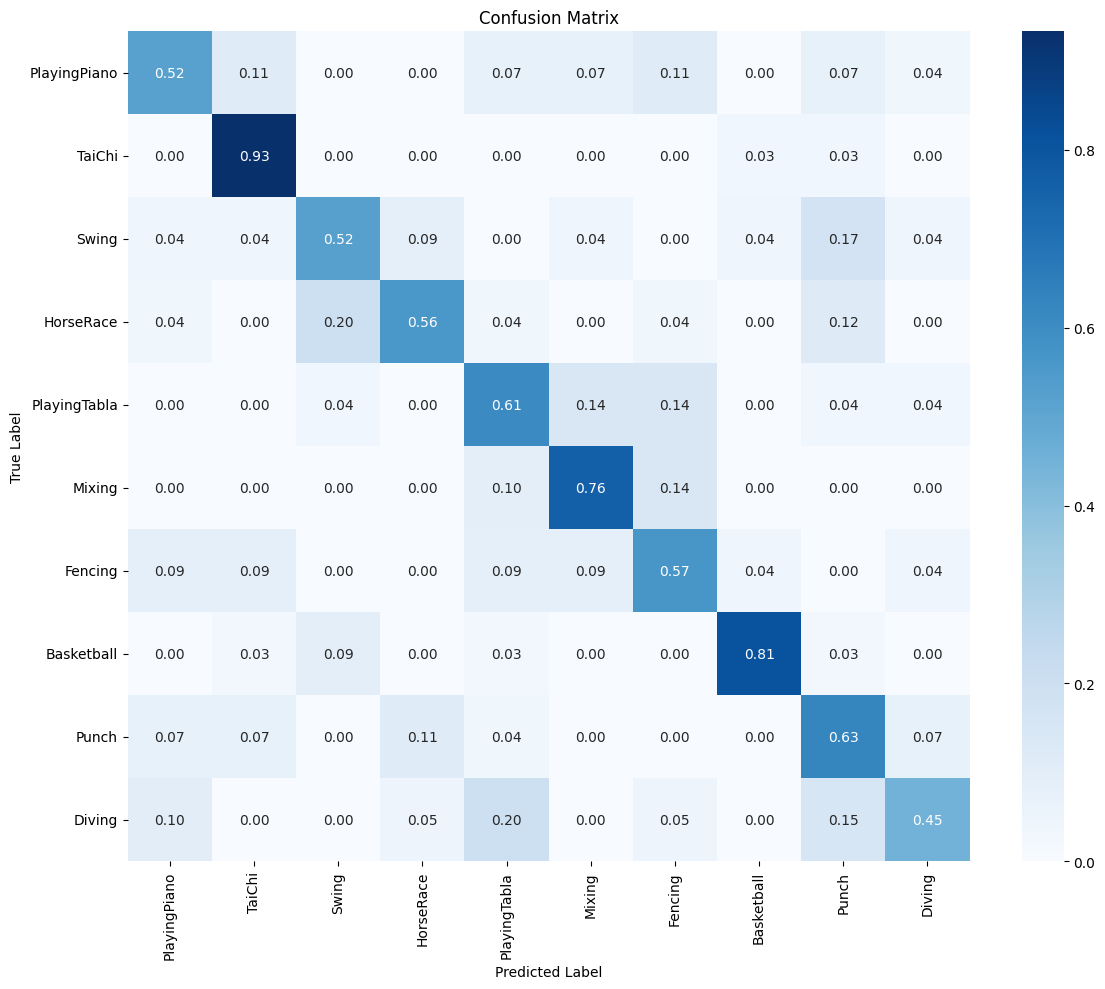

<Figure size 1400x800 with 0 Axes>

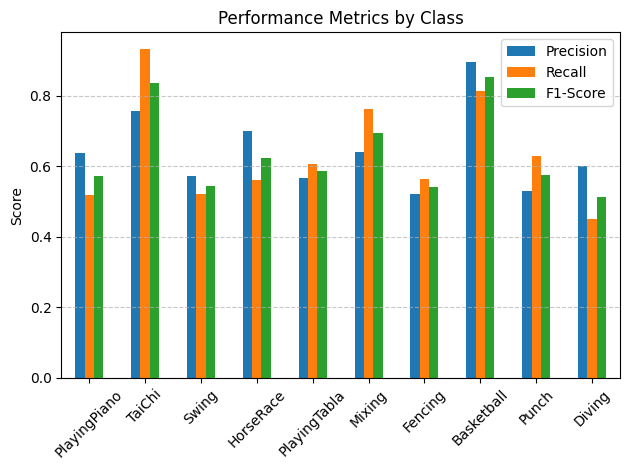

In [16]:
train_model()

In [17]:
# !tensorboard --logdir=/kaggle/working/save_dir/run/run_2/models/Apr25_19-00-55_e8a416e980c9

In [18]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import os
import matplotlib.pyplot as plt
import glob
from datetime import datetime

In [19]:
# Load extension
%load_ext tensorboard

In [20]:
# os.listdir("/kaggle/working/save_dir/run/run_1/models/Apr29_09-07-19_dfd9a178798b")

In [21]:
def find_latest_run(base_dir="/kaggle/working/save_dir/run"):
    """Find the latest run directory based on timestamp in folder name."""
    # Find all run directories
    run_dirs = glob.glob(os.path.join(base_dir, "run_*"))
    
    if not run_dirs:
        raise FileNotFoundError(f"No run directories found in {base_dir}")
    
    # If there's only one run directory, use it
    if len(run_dirs) == 1:
        latest_run = run_dirs[0]
    else:
        # If there are multiple, find the latest one based on directory name
        # Assuming directory names include run_1, run_2, etc.
        latest_run = max(run_dirs, key=lambda x: int(os.path.basename(x).split('_')[1]))
    
    return latest_run

In [22]:
def find_latest_event_file(run_dir):
    """Find the latest event file within the models directory."""
    # Find all models directories (they should contain date-based names)
    model_dirs = glob.glob(os.path.join(run_dir, "models", "*"))
    
    if not model_dirs:
        raise FileNotFoundError(f"No model directories found in {run_dir}/models")
    
    # Extract timestamps from directory names
    # Assuming format like Apr29_09-07-19_dfd9a178798b
    latest_model_dir = None
    latest_timestamp = None
    
    for model_dir in model_dirs:
        dir_name = os.path.basename(model_dir)
        if '_' in dir_name:
            try:
                # Parse the date part (e.g., Apr29_09-07-19)
                date_str = '_'.join(dir_name.split('_')[:2])
                timestamp = datetime.strptime(date_str, "%b%d_%H-%M-%S")
                
                if latest_timestamp is None or timestamp > latest_timestamp:
                    latest_timestamp = timestamp
                    latest_model_dir = model_dir
            except (ValueError, IndexError):
                # If parsing fails, continue to the next directory
                continue
    
    if latest_model_dir is None:
        # If timestamp-based approach failed, just take the most recently modified directory
        latest_model_dir = max(model_dirs, key=os.path.getmtime)
    
    # Find event file in the latest model directory
    event_files = glob.glob(os.path.join(latest_model_dir, "events.out.tfevents.*"))
    
    if not event_files:
        raise FileNotFoundError(f"No event files found in {latest_model_dir}")
    
    # If multiple event files exist, take the most recent one
    latest_event_file = max(event_files, key=os.path.getmtime)
    
    return latest_event_file

In [23]:
def plot_tensorboard_metrics(event_file):
    """Plot accuracy and loss curves from TensorBoard events file."""
    # Tags for metrics to extract
    accuracy_tags = ['data/train_acc_epoch', 'data/val_acc_epoch', 'data/test_acc_epoch']
    loss_tags = ['data/train_loss_epoch', 'data/val_loss_epoch', 'data/test_loss_epoch']
    
    # Load events
    ea = EventAccumulator(event_file)
    ea.Reload()  # Load everything
    
    available_tags = ea.Tags()['scalars']
    print(f"Available tags: {available_tags}")
    
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot accuracy curves
    ax1.set_title('Accuracy Curves')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    
    for tag in accuracy_tags:
        if tag in available_tags:
            events = ea.Scalars(tag)
            steps = [e.step for e in events]
            values = [e.value for e in events]
            label = tag.split('/')[-1].replace('_epoch', '').capitalize()
            ax1.plot(steps, values, marker='o', label=label)
        else:
            print(f"Tag not found: {tag}")
    
    ax1.legend()
    ax1.grid(True)
    
    # Plot loss curves
    ax2.set_title('Loss Curves')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    
    for tag in loss_tags:
        if tag in available_tags:
            events = ea.Scalars(tag)
            steps = [e.step for e in events]
            values = [e.value for e in events]
            label = tag.split('/')[-1].replace('_epoch', '').capitalize()
            ax2.plot(steps, values, marker='o', label=label)
        else:
            print(f"Tag not found: {tag}")
    
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return fig

Found latest run directory: /kaggle/working/save_dir/run/run_0
Found latest event file: /kaggle/working/save_dir/run/run_0/models/Apr29_11-55-25_4babb9634ae6/events.out.tfevents.1745927725.4babb9634ae6


2025-04-29 12:31:30.952632: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745929891.251823      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745929891.333000      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Available tags: ['data/train_loss_epoch', 'data/train_acc_epoch', 'data/test_loss_epoch', 'data/test_acc_epoch']
Tag not found: data/val_acc_epoch
Tag not found: data/val_loss_epoch


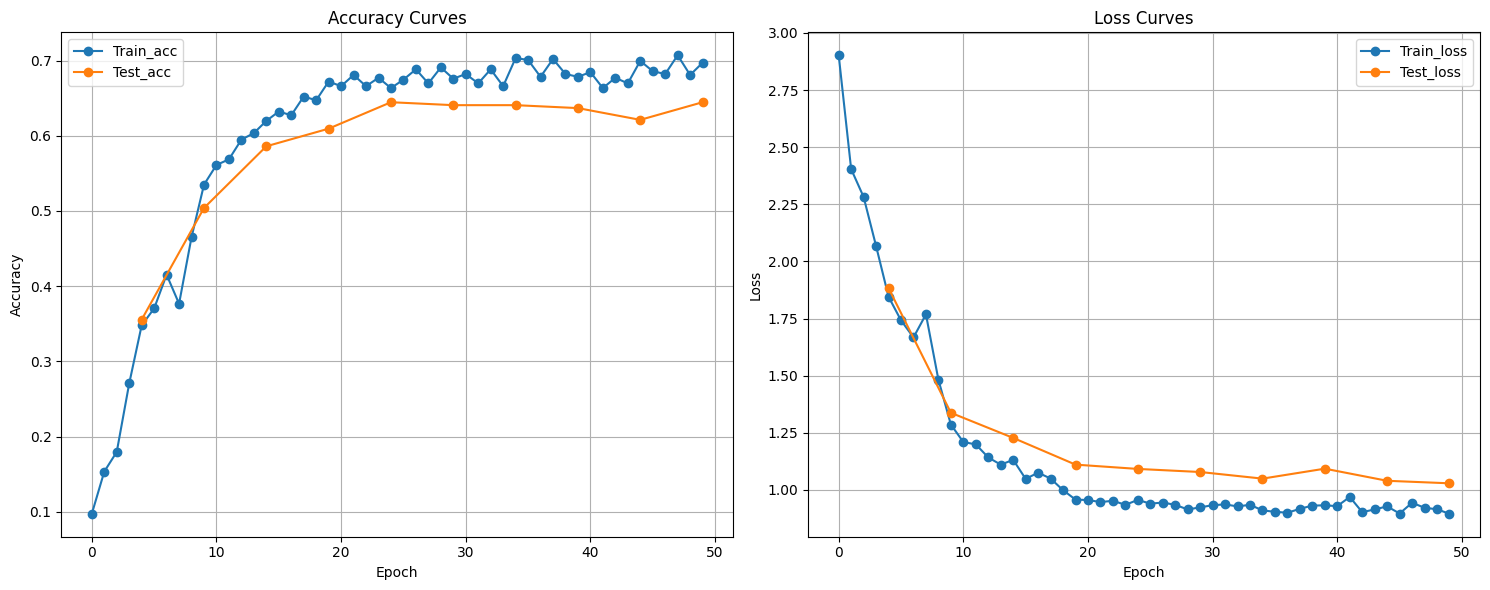

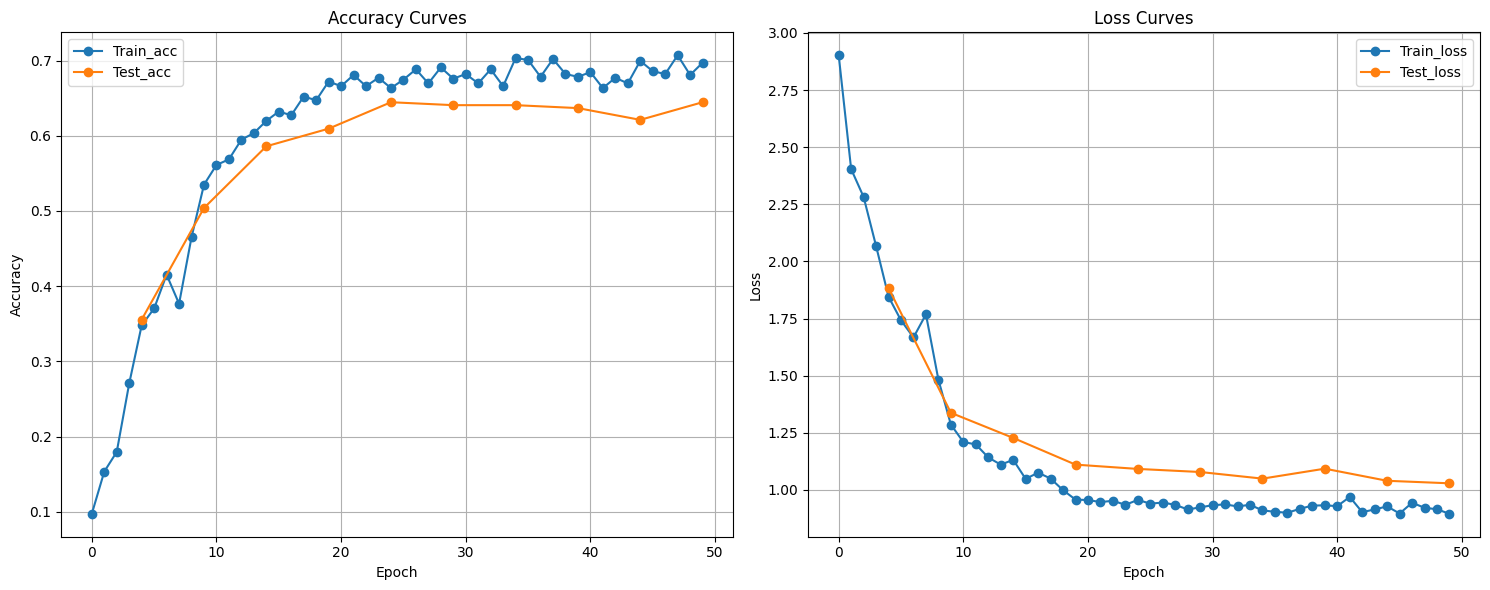

In [24]:
# Find the latest run directory
latest_run = find_latest_run()
print(f"Found latest run directory: {latest_run}")

# Find the latest event file
latest_event_file = find_latest_event_file(latest_run)
print(f"Found latest event file: {latest_event_file}")

# Plot the metrics
plot_tensorboard_metrics(latest_event_file)